In [119]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import pymetis
import networkx as nx
import time
from networkx.algorithms import community
from random import shuffle
import math
import torch
import torch.nn as nn
import torch_geometric as tg
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops, degree
from torch.nn import init
import pdb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader, random_split
from torch_geometric.data import Data
import torch.optim as optim
import pywt
from scipy.stats import norm
import scipy.interpolate as interp
from IPython.display import clear_output
import matplotlib.ticker as mticker

In [120]:
def open_data(file_path):
    file = open(file_path,"rb")
    raw_data = pickle.load(file)  
    return raw_data

In [121]:
class NonLinearOperate(nn.Module):
    def __init__(self, input_dimen, hidden_dimen, output_dimen):
        super(NonLinearOperate, self).__init__()  #类NonLinearLayer继承父类nn.Module的初始化方法
        self.layer_1 = nn.Linear(input_dimen, hidden_dimen)
        self.layer_2 = nn.Linear(hidden_dimen, output_dimen)
        self.acti_func = nn.ReLU()
        for m in self.modules():#遍历所有子模块
#Check if each sub-module is an example of the class nn.Linear
            if isinstance(m, nn.Linear):
                m.weight.data = init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
                #m.weight.data = init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))#Use Xavier initialization
                if m.bias is not None:
                    m.bias.data = init.constant_(m.bias.data, 0.0)
            
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.acti_func(x)
        x = self.layer_2(x)
        
        
        return x

In [122]:
class PGNN_Layer(nn.Module):
    def __init__(self, input_dimen, output_dimen, max_ach_num):
        super(PGNN_Layer, self).__init__()
        self.input_dimen = input_dimen
        self.output_dimen = output_dimen
        self.distance_calculate = NonLinearOperate(1, output_dimen, 1)
        self.acti_func = nn.ReLU()
        self.linear_hidden = nn.Linear(2*input_dimen, output_dimen)
        self.out_transition = nn.Linear(output_dimen,1)
        self.linear_out_position = nn.Linear(max_ach_num,input_dimen)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
                if m.bias is not None:
                    m.bias.data = init.constant_(m.bias.data, 0.0)                
                    
    def forward(self, node_features, dists_max, dists_argmax):
        dists_max = self.distance_calculate(dists_max.unsqueeze(-1)).squeeze()
        subset_features = node_features[dists_argmax.flatten(), :]
        subset_features = subset_features.reshape(dists_argmax.shape[0], dists_argmax.shape[1], subset_features.shape[1])
        messages = subset_features * dists_max.unsqueeze(-1)
        feature_self = node_features.unsqueeze(1).repeat(1, dists_max.shape[1],1)
        messages = torch.concat((messages, feature_self), dim = -1) #N行M列D维
        messages = self.linear_hidden(messages).squeeze()#将输出维度改为Output Dimen,即n*m*output_dimen
        messages = self.acti_func(messages) 
        output_transition = self.out_transition(messages).squeeze(-1) #n * m * output_dimen to n * m
        output_position = self.linear_out_position(output_transition)
        output_structure = torch.mean(messages, dim=1)#n*output_dimen
        
        return output_position, output_structure

In [123]:
class PGNN(nn.Module):
    def __init__(self, input_dimen, hidden_dimen, output_dimen, max_ach_num, layer_num = 1, drop_out = True):
        super(PGNN, self).__init__()
        self.drop_out = drop_out
        self.layer_num = layer_num
        self.input_layer = nn.Linear(input_dimen, hidden_dimen)
        self.last_layer = nn.Linear(hidden_dimen, input_dimen)
        self.max_ach_num = max_ach_num
        if self.layer_num == 1:
            self.gnn_operate_1 = PGNN_Layer(hidden_dimen, output_dimen, max_ach_num)#输出维度是node_num * hidden_dimen
            
        if self.layer_num > 1:
            self.gnn_hidden = nn.ModuleList([PGNN_Layer(hidden_dimen, hidden_dimen, max_ach_num) for i in range(0, layer_num)])
            self.gnn_output_layer = PGNN_Layer(hidden_dimen, output_dimen)
                
        
    def forward(self, x, dist_max_sets, dist_argmax_sets):
        
        x = self.input_layer(x)
        if self.layer_num == 1:
            x_position, x = self.gnn_operate_1(x, dist_max_sets[0,:,:], dist_argmax_sets[0,:,:])
            if self.drop_out:
                x = F.dropout(x, training=self.training)
            x_position = self.last_layer(x_position)
            #print(f"pgnn output_layer size: {x_position.shape}")
            return x_position
    
        if self.layer_num > 1:
            for i in range(self.layer_num):
                _, x = self.gnn_hidden[i](x, dist_max_sets[i,:,:], dist_argmax_sets[i,:,:])
                if self.drop_out:
                    x = F.dropout(x, training=self.training)
                  
            _ = F.normalize(_, p=2, dim=-1)
            x_position = self.last_layer(_)    
            
            
            return x_position

In [124]:
class P_GCN(nn.Module):
    def __init__(self, input_dimen, hidden_dimen, output_dimen, max_ach_num, layer_num = 1, drop_out = True):
        super(P_GCN, self).__init__()
        self.max_ach_num = max_ach_num
        self.layer_num = layer_num
        self.drop_out = drop_out
        self.input_layer = nn.Linear(input_dimen, hidden_dimen)
        self.p_gcn_block = nn.Sequential(PGNN_Layer(hidden_dimen, hidden_dimen, max_ach_num), 
                                         GCNConv(hidden_dimen, hidden_dimen, add_self_loops=True))
        self.acti_func = nn.ReLU()   
        
        if layer_num == 1:
            self.gcn_p_layers = self.p_gcn_block
        if layer_num > 1:
            self.gcn_p_layers = nn.ModuleList([self.p_gcn_block for i in range(layer_num)])
            
        self.output_layer = nn.Linear(hidden_dimen, output_dimen)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
                if m.bias is not None:
                    m.bias.data = init.constant_(m.bias.data, 0.0)   
        
        
    def forward(self, x, edge_index, dist_max, dist_argmax):#GCN_P_input shape: node_num, 4
        
        x_ = self.input_layer(x)
        
        if self.layer_num == 1:
            x_position, _ = self.gcn_p_layers[0](x_, dist_max[0,:,:], dist_argmax[0,:,:])
            if self.drop_out:
                x_position = F.dropout(x_position, training=self.training)
            x = self.gcn_p_layers[1](x_position, edge_index)
            if self.drop_out:
                x = F.dropout(x, training=self.training)
            x = self.acti_func(x + x_)
            
        else:
            for i in range(self.layer_num):
                x_position, _ = self.gcn_p_layers[i][0](x_, dist_max[i,:,:], dist_argmax[i,:,:])
                if self.drop_out:
                    x_position = F.dropout(x_position, training=self.training)
                x = self.gcn_p_layers[i][1](x_position, edge_index)
                if self.drop_out:
                    x = F.dropout(x, training=self.training)
                x = self.acti_func(x + x_)
                x_ = x
                    
        x = self.acti_func(self.output_layer(x))
    
        return x

In [125]:
#输入数据shape: node_num, 4, time_step(20)
class CNN_1D(nn.Module):
    def __init__(self, input_channels, hidden_channels_1, hidden_channels_2, out_channels):
        super(CNN_1D, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels = input_channels, out_channels = hidden_channels_1, kernel_size = 3, padding=1),
            nn.BatchNorm1d(hidden_channels_1),
            nn.ReLU(),
            nn.Conv1d(in_channels = hidden_channels_1, out_channels = hidden_channels_2, kernel_size = 3, padding=0),
            nn.BatchNorm1d(hidden_channels_2),
            nn.ReLU(), #len: 18
            nn.MaxPool1d(kernel_size=2, stride=2),#(18-2)/2 +1 =9
            nn.ConvTranspose1d(in_channels= hidden_channels_2,
                               out_channels=out_channels,
                               kernel_size=4,
                               stride= 2, 
                               padding=0))

        self.fc1 = nn.Linear(out_channels, 8)
    
    def forward(self, x):
        out = self.layer1(x)
        #output shape: change from batch_num, out_channels, t-step to batch_num, t-step, out_channels
        out = out.permute(0, 2, 1)
        out = self.fc1(out)
        #output shape: batch_num, t-step, 4
        return out

In [126]:
class GRU(nn.Module):
    def __init__(self, input_dimen, hidden_dimen, pred_len, output_dimen = 4, num_layers = 2):
        super(GRU, self).__init__()
        self.hidden_dimen = hidden_dimen
        self.output_dimen = output_dimen
        self.num_layers = num_layers
        self.linear_layer_1 = nn.Linear(input_dimen, hidden_dimen)
        self.linear_layer_2 = nn.Linear(20, pred_len)
        self.gru_layers = nn.GRU(hidden_dimen, output_dimen, num_layers, batch_first = True)
        self.acti_func = nn.ReLU()
         
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
                if m.bias is not None:
                    m.bias.data = init.constant_(m.bias.data, 0.0)               
            
            
    #gru输入格式：node_num, t-steps, hidden_dimen
    def forward(self, pgnn_t_step_outs, extractor_outputs):  
        x = torch.cat((pgnn_t_step_outs, extractor_outputs), dim = -1)
        #x shape: node_num, t-steps, 2 * 4
        batch_size, seq_len, feat_dim = x.size()
        x = self.acti_func(self.linear_layer_1(x))
        x = self.acti_func(self.linear_layer_2(x.permute(0,2,1)))
        h_0 = torch.zeros(self.num_layers, batch_size, self.output_dimen)
        outputs, _ = self.gru_layers(x.permute(0,2,1), h_0)#outputs shape: batch_size, pred_len, output_dimen. 
        x = self.acti_func(outputs)
    
        
        return x

In [127]:
class T_Step_PGNN(nn.Module):
    def __init__(self, input_dimen, hidden_dimen, output_dimen, max_ach_num, layer_num = 1):
        super(T_Step_PGNN, self).__init__()
        self.pgnn_model = PGNN(input_dimen, hidden_dimen, output_dimen, max_ach_num, layer_num)
        
    def forward(self, t_step_inputs, subgraph_nodes, dist_max, dist_argmax): #t-step-inputs shape: 20, max_subgraph_nodenumber,4
        pgnn_template = torch.zeros((t_step_inputs.shape[0], t_step_inputs.shape[1], t_step_inputs.shape[2]))
        
        pgnn_outputs = torch.empty((0,subgraph_nodes.shape[0],t_step_inputs.shape[2]))
        subgraph_node_num = subgraph_nodes.shape[0]
            
        for t in range(t_step_inputs.shape[0]):
            pgnn_t_step = self.pgnn_model(t_step_inputs[t,:subgraph_node_num,:], dist_max[:,:,:], dist_argmax[:,:,:])
            pgnn_outputs = torch.cat((pgnn_outputs, pgnn_t_step.unsqueeze(0)), dim=0)
        
        pgnn_template[:,:subgraph_node_num,:] = pgnn_outputs
        
        return pgnn_template

In [128]:
class T_Step_PGCN(nn.Module):
    def __init__(self, input_dimen, hidden_dimen, output_dimen, max_ach_num, layer_num = 1):
        super(T_Step_PGCN, self).__init__()
        self.pgcn_model = P_GCN(input_dimen, hidden_dimen, output_dimen, max_ach_num, layer_num)
        self.output_dimen = output_dimen
        
    def forward(self, t_step_inputs, subgraph_nodes, edge_index, dist_max, dist_argmax): #t-step-inputs shape: 20, max_subgraph_nodenumber,4
        pgcn_template = torch.zeros((t_step_inputs.shape[0], t_step_inputs.shape[1], self.output_dimen))
        pgcn_outputs = torch.empty((0,subgraph_nodes.shape[0],self.output_dimen))
        #pgcn_template = torch.zeros((t_step_inputs.shape[0], t_step_inputs.shape[1], t_step_inputs.shape[2]))
        #pgcn_outputs = torch.empty((0,subgraph_nodes.shape[0],t_step_inputs.shape[2]))
        subgraph_node_num = subgraph_nodes.shape[0]
            
        for t in range(t_step_inputs.shape[0]):
            pgcn_t_step = self.pgcn_model(t_step_inputs[t,:subgraph_node_num,:], edge_index, dist_max[:,:,:], dist_argmax[:,:,:])
            pgcn_outputs = torch.cat((pgcn_outputs, pgcn_t_step.unsqueeze(0)), dim=0)
        
        pgcn_template[:,:subgraph_node_num,:] = pgcn_outputs
        
        return pgcn_template        
        


In [129]:
class Feature_Extractor(nn.Module):
    def __init__(self, input_dimen, hidden_dimen, output_dimen, max_ach_num,
                input_channels, hidden_channels_1, hidden_channels_2, out_channels, layer_num = 1):
        super(Feature_Extractor, self).__init__()
        self.pgcn_model = P_GCN(input_dimen, hidden_dimen, output_dimen, max_ach_num, layer_num = layer_num)
        self.cnn_1D = CNN_1D(input_channels, hidden_channels_1, hidden_channels_2, out_channels)
        self.output_dimen = output_dimen
         
    def forward(self, t_step_inputs, edge_index, subgraph_nodes, dist_max, dist_argmax): 
        pgcn_template = torch.zeros((t_step_inputs.shape[0], t_step_inputs.shape[1], self.output_dimen))
        pgcn_outputs = torch.empty((0, subgraph_nodes.shape[0], self.output_dimen))
        #pgcn_template = torch.zeros((t_step_inputs.shape[0], t_step_inputs.shape[1], t_step_inputs.shape[2]))
        #pgcn_outputs = torch.empty((0,subgraph_nodes.shape[0],t_step_inputs.shape[2]))
        
        subgraph_node_num = subgraph_nodes.shape[0]
            
            
        for t in range(t_step_inputs.shape[0]):
            pgcn_t_step = self.pgcn_model(t_step_inputs[t,:subgraph_node_num,:], edge_index, dist_max[:,:,:], dist_argmax[:,:,:])
            pgcn_outputs = torch.cat((pgcn_outputs, pgcn_t_step.unsqueeze(0)), dim=0)
            
        pgcn_template[:,:subgraph_node_num,:] = pgcn_outputs
            
            
        #shape changed as: node_num, 4, time_step
        pgcn_template =pgcn_template.permute(1,2,0)
        extractor_outputs = self.cnn_1D(pgcn_template).permute(1, 0, 2)
        #cnn_output shape changed from node_num, t-step, 4 to t-step, node_num, 4 
        
        return extractor_outputs

In [130]:
def sort_pooling(extractor_outputs, k):
    norms = torch.norm(extractor_outputs, p=2, dim= -1)
    #print("norm shape", norms.shape)
    _, sorted_indices = torch.sort(norms, dim= -1, descending=True)
    sorted_outputs = torch.gather(extractor_outputs, dim=1, index=sorted_indices.unsqueeze(-1).expand(-1, -1, extractor_outputs.size(-1)))
    k_nodes_outputs = sorted_outputs[:, : k , :]
    
    return k_nodes_outputs

In [157]:
class Discriminator(nn.Module):
    def __init__(self, input_dimen, hidden_dimen, k, seq_len=20, num_class=3, layer_num = 1):
        super(Discriminator, self).__init__()
        self.k = k
        self.layer_num = layer_num
        self.batch_norm = nn.BatchNorm1d(num_features = input_dimen)
        self.input_layer = nn.Sequential(nn.Flatten(start_dim=1, end_dim=-1),nn.Linear(input_dimen * k,hidden_dimen), nn.LeakyReLU(),
                                         nn.Flatten(start_dim=0,end_dim=-1),nn.Linear(seq_len * hidden_dimen,hidden_dimen, nn.LeakyReLU()))      
        self.acti_func = nn.LeakyReLU()
        
        
        if layer_num == 1:
            self.linear_layers = nn.Linear(hidden_dimen, num_class)
        elif layer_num > 1:
            self.linear_layers = nn.ModuleList([nn.Linear(hidden_dimen, hidden_dimen), nn.LeakyReLU()] * (layer_num - 1))
            self.linear_layers.append(nn.Linear(hidden_dimen, num_class))
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
                if m.bias is not None:
                    m.bias.data = init.constant_(m.bias.data, 0.0)
        
        
    def forward(self, extractor_outputs):
        k_nodes_outputs = sort_pooling(extractor_outputs, self.k)
        flattened_k_nodes_outputs = torch.reshape(k_nodes_outputs, (-1, k_nodes_outputs.shape[2]))
        norm_x = self.batch_norm(flattened_k_nodes_outputs)
        x = self.input_layer(norm_x.reshape(k_nodes_outputs.shape[0],-1,k_nodes_outputs.shape[2]))
        
        if self.layer_num == 1:
            x = self.linear_layers(self.acti_func(x))#Shape: num_class
            
        else:
            for layer in self.linear_layers:
                x = layer(x)
    
        
        return x

In [158]:
class CustomData(Data):
    def __init__(self, trend, period, target_volume, target_label, edge_pairs, subgraph_node_num, subgraph_nodes, city_node_num, 
                 dist_max, dist_argmax, min_vals, max_vals):
        super(CustomData, self).__init__()
        self.trend = trend
        self.period = period
        self.target_volume = target_volume
        self.target_label = target_label
        self.edge_pairs = edge_pairs
        self.subgraph_node_num = subgraph_node_num
        self.subgraph_nodes = subgraph_nodes
        self.city_node_num = city_node_num
        self.dist_max = dist_max
        self.dist_argmax = dist_argmax
        self.min_vals = min_vals
        self.max_vals = max_vals

In [159]:
#PGCN:
#input_dimen, hidden_dimen, output_dimen = 4, 16 ,4
input_dimen, hidden_dimen, output_dimen = 4, 16 ,8
max_ach_num = 50

#1-d Conv
#input_channels, hidden_channels_1, hidden_channels_2, out_channels = 4, 8, 16, 8
input_channels, hidden_channels_1, hidden_channels_2, out_channels = 8, 16, 16, 8

#GRU
#gru_input_dimen = 8
gru_input_dimen = 16

num_class = 3 
layer_num = 1

k = 60
pred_len = 10
seq_len =20
alpha = 0.7

In [165]:
#-----------------------PGNN----------------------------
#pgnn_model = T_Step_PGNN(input_dimen, hidden_dimen, output_dimen, max_ach_num)

pgcn_model = T_Step_PGCN(input_dimen, hidden_dimen, output_dimen, max_ach_num)
    
#-------------------Feature Extractor----------------------   
feature_extractor = Feature_Extractor(input_dimen, hidden_dimen, output_dimen, max_ach_num,
                                      input_channels, hidden_channels_1, hidden_channels_2, out_channels, layer_num)

#-------------------Discriminator-----------------------------
#discriminator = Discriminator(input_dimen, hidden_dimen, k, seq_len, num_class, layer_num)

#------------------Predictor-----------------------------------
predictor = GRU(gru_input_dimen, hidden_dimen, pred_len)

In [166]:
#Class tables: ANT 0: 12 -- BANG 1: 14 -- MOSCOW 2: 16
#class_weights = torch.tensor([40/12, 40/14, 40/16])
#criterion_discriminator = nn.CrossEntropyLoss(weight=class_weights)
criterion_regression_MSE = nn.MSELoss(reduction='sum')
#optimizer_extractor = optim.AdamW(list(feature_extractor.parameters())+list(pgcn_model.parameters())+list(predictor.parameters()), lr=0.0004, weight_decay= 0.00001)
optimizer_extractor = optim.Adam(list(feature_extractor.parameters())+list(pgcn_model.parameters())+list(predictor.parameters()), lr=0.0006, weight_decay=0.00001)
#optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.0009)

In [136]:
purpose = "train"
root_path = "D:/ThesisData/processed data/"
#file_path = root_path + f'Barcelona/input_target/train_regional_level.pt'
file_path = root_path + f'SourceDomain/regional_loaders/{purpose}.pt'
data = torch.load(file_path)


In [137]:
vali_data = torch.load('D:/ThesisData/processed data/SourceDomain/regional_loaders/vali.pt')

In [162]:
print(len(data))
batch_size = 14
batch_num = len(data)//batch_size
print(batch_num)

1092
78


In [163]:
vali_batch_num = len(vali_data)//batch_size
print(vali_batch_num)

26


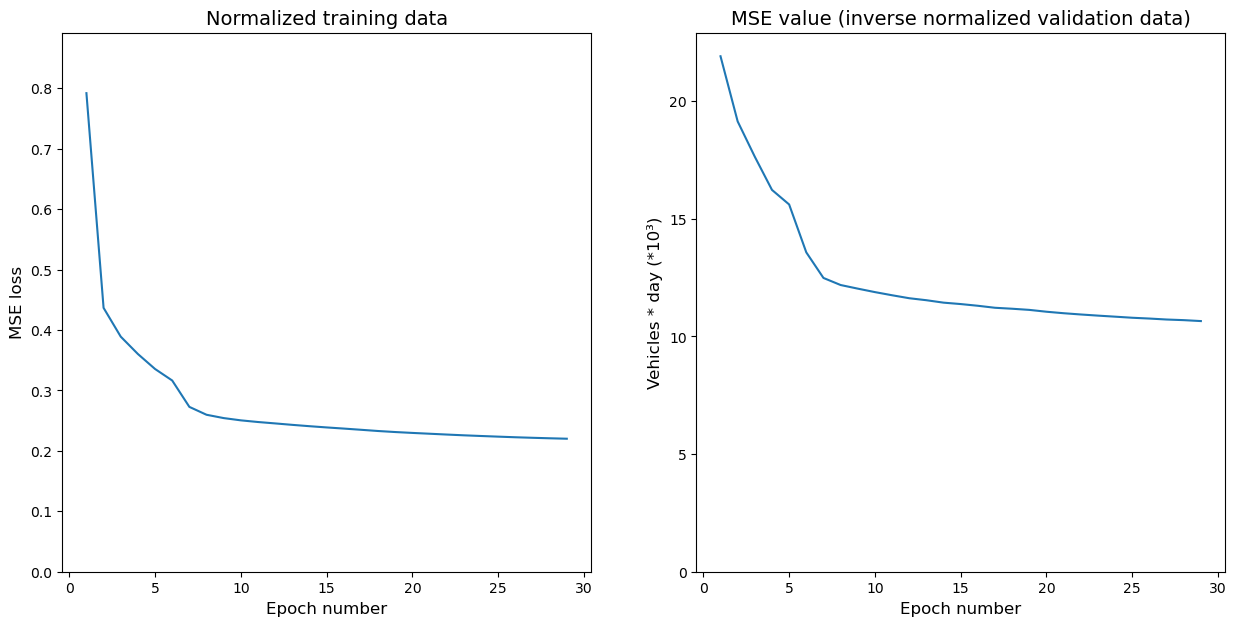

After batch 0, MSE loss: 0.2666334807872772, MAE loss: 0.9577646255493164
After batch 1, MSE loss: 0.26624175906181335, MAE loss: 0.9392799139022827
After batch 2, MSE loss: 0.2646791934967041, MAE loss: 0.9335399866104126
After batch 3, MSE loss: 0.2388741821050644, MAE loss: 0.8824023008346558
After batch 4, MSE loss: 0.24217349290847778, MAE loss: 0.9080060720443726
After batch 5, MSE loss: 0.2510393559932709, MAE loss: 0.9534886479377747
After batch 6, MSE loss: 0.2516200840473175, MAE loss: 0.9456925392150879
After batch 7, MSE loss: 0.25656598806381226, MAE loss: 0.9490629434585571
After batch 8, MSE loss: 0.23079712688922882, MAE loss: 0.8665260672569275
After batch 9, MSE loss: 0.17872512340545654, MAE loss: 0.7578116059303284
After batch 10, MSE loss: 0.19066423177719116, MAE loss: 0.7878313064575195
After batch 11, MSE loss: 0.18446224927902222, MAE loss: 0.776947557926178
After batch 12, MSE loss: 0.17739541828632355, MAE loss: 0.7366514205932617
After batch 13, MSE loss: 0.

In [ ]:
epoch_num =40
plt.ion() 
#---------collect train set value-------------
train_mse_losses = []
train_mae_losses = []
#--------collect vali set value---------------
vali_mse_losses = []
vali_mae_losses = []
#---------------------------------------------
epoch_numbers = []

for h in range(epoch_num):
    train_mse_loss =0.0
    train_mae_loss = 0.0
    
    feature_extractor.train()
    pgcn_model.train()
    predictor.train()
    
    for b in range(batch_num):
        batch = data[b: b + batch_size]
        all_subgraph_nodes = sum([batch[i].subgraph_node_num for i in range(len(batch))])
        
        #one_batch_discriminator = []
        #one_batch_extractor = []
        one_batch_predictor = []
        #one_batch_discriminator = []
        
        target_volumes = []
        #target_labels = []
        #Each Batch Covers batch_size data files
        for i in range(len(batch)):
    
            #extractor outputs Shape: T-step, Node_num, 4
            extractor_outputs = feature_extractor(batch[i].trend, batch[i].edge_pairs, batch[i].subgraph_nodes, batch[i].dist_max, batch[i].dist_argmax)    
            pgcn_period_outputs = pgcn_model(batch[i].period, batch[i].subgraph_nodes, batch[i].edge_pairs, batch[i].dist_max, batch[i].dist_argmax)
                
                
            #discriminator_out = discriminator(extractor_outputs.detach())
                
        
            predictor_output = predictor(extractor_outputs.permute(1, 0, 2), pgcn_period_outputs.permute(1, 0, 2))
            predictor_output = predictor_output.permute(1, 0, 2)
                                      
            
            #one_batch_extractor.append(extractor_outputs)
            #one_batch_discriminator.append(discriminator_out)
            one_batch_predictor.append(predictor_output)
            
            
            target_volumes.append(batch[i].target_volume)  
            #target_label = batch[i].target_label
            #target_labels.append(target_label)
                    
                
        #one_batch_extractor = torch.stack(one_batch_extractor)  
        #one_batch_discriminator = torch.stack(one_batch_discriminator)
        one_batch_predictor = torch.stack(one_batch_predictor)
    
    
        target_volumes = torch.stack(target_volumes)  
        #target_labels = torch.tensor(target_labels).to(torch.long)  
        
        
        
        
        #---------Update the Para of Discriminator-----------
        #optimizer_discriminator.zero_grad()
        #loss_discriminator = criterion_discriminator(one_batch_discriminator, target_labels)
        #loss_discriminator.backward()
        #optimizer_discriminator.step()
        #------------------------------------------------------

        
        #--------Update Feature Extractor Para-------------
        #one_batch_discriminator = torch.empty((0, discriminator_out.shape[0]))
        #for i in range(one_batch_extractor.shape[0]):
            #discriminator_out = discriminator(one_batch_extractor[i,:,:,:])
            #one_batch_discriminator = torch.cat((one_batch_discriminator,discriminator_out.unsqueeze(0)), dim = 0)
        
        
        #loss_discriminator = criterion_discriminator(one_batch_discriminator, target_labels)
        loss_mse = criterion_regression_MSE(one_batch_predictor, target_volumes) / all_subgraph_nodes
        loss_mae =torch.sum(torch.abs(one_batch_predictor - target_volumes)) / all_subgraph_nodes
        #----------------------------------------------
        train_mse_loss += loss_mse.item()
        train_mae_loss += loss_mae.item()
        #-----------------------------------------------
        
        print(f"After batch {b}, MSE loss: {loss_mse}, MAE loss: {loss_mae}")      
        #disriminator loss: {loss_discriminator}"
        
        optimizer_extractor.zero_grad()
        loss_feat_ext = loss_mse #+ alpha * (-loss_discriminator) 
        loss_feat_ext.backward() #(retain_graph=True)
        optimizer_extractor.step()      
        
     
    
    train_mse_loss /= batch_num
    train_mae_loss /= batch_num   
    train_mse_losses.append(train_mse_loss)
    train_mae_losses.append(train_mae_loss)
        
    
    print("=================================================")
    feature_extractor.eval()
    pgcn_model.eval()
    #discriminator.eval()
    predictor.eval()
    
    vali_mse_loss = 0.0
    vali_mae_loss = 0.0
    
    with torch.no_grad():
        for b in range(vali_batch_num):
            batch = vali_data[b: b + batch_size]
            all_subgraph_nodes = sum([batch[i].subgraph_node_num for i in range(len(batch))])
        
            #one_batch_discriminator = []
            #one_batch_extractor = []
            one_batch_predictor = []
        
            target_volumes = []
            #target_labels = []     
            for i in range(len(batch)):
                extractor_outputs = feature_extractor(batch[i].trend, batch[i].edge_pairs, batch[i].subgraph_nodes, batch[i].dist_max, batch[i].dist_argmax)    
                
                    
                pgcn_period_outputs = pgcn_model(batch[i].period, batch[i].subgraph_nodes, batch[i].edge_pairs, batch[i].dist_max, batch[i].dist_argmax)
                

                #discriminator_out = discriminator(extractor_outputs)
                predictor_output = predictor(extractor_outputs.permute(1, 0, 2), pgcn_period_outputs.permute(1, 0, 2))
                predictor_output = predictor_output.permute(1, 0, 2)
                
                #将结果反归一化-------------------------------------
                min_vals = torch.round(batch[i].min_vals.unsqueeze(0).unsqueeze(0))
                max_vals = torch.round(batch[i].max_vals.unsqueeze(0).unsqueeze(0))  
                predictor_output[:,:batch[i].subgraph_node_num,:] = torch.round(predictor_output[:,:batch[i].subgraph_node_num,:]*(max_vals- min_vals) + min_vals) 
            
            
                #one_batch_extractor.append(extractor_outputs)
                #one_batch_discriminator.append(discriminator_out)
                one_batch_predictor.append(predictor_output)
            
               
                target_volume = torch.zeros_like(batch[i].target_volume)  
                target_volume[:,:batch[i].subgraph_node_num,:] = torch.round(batch[i].target_volume[:,:batch[i].subgraph_node_num,:]*(max_vals- min_vals) + min_vals) 
                target_volumes.append(target_volume)  
                #target_label = batch[i].target_label
                #target_labels.append(target_label)  
                
                
                print(f'max predictor values: {torch.max(predictor_output)}')   
                print(f'target volume values: {torch.max(target_volume)}')  
                
                
            #one_batch_extractor = torch.stack(one_batch_extractor)  
            #one_batch_discriminator = torch.stack(one_batch_discriminator)
            one_batch_predictor = torch.stack(one_batch_predictor)
    
            target_volumes = torch.stack(target_volumes)                  
            #target_labels = torch.tensor(target_labels).to(torch.long)     
            
                      
            
            #loss_discriminator = criterion_discriminator(one_batch_discriminator, target_labels)
            loss_mse = criterion_regression_MSE(one_batch_predictor, target_volumes) / all_subgraph_nodes
            loss_mae =torch.sum(torch.abs(one_batch_predictor - target_volumes)) / all_subgraph_nodes
            vali_mse_loss +=  loss_mse.item()
            vali_mae_loss += loss_mae.item()
            print(f"After batch {b}, MSE loss: {loss_mse}, MAE loss: {loss_mae}")  
            
    vali_mse_loss /= vali_batch_num
    vali_mae_loss /= vali_batch_num
    vali_mse_losses.append(vali_mse_loss)
    vali_mae_losses.append(vali_mae_loss)
    
    #------------------------------------------------------------------
    epoch_numbers.append(h+1)
    
    clear_output(wait=True)  #清除上一次的输出
    fig, axs = plt.subplots(1,2, figsize=(15,7))
    axs[0].plot(epoch_numbers, train_mse_losses)
    axs[0].tick_params(axis='both',labelsize=10)
    axs[0].set_ylim(0,max(train_mse_losses)+0.1)
    axs[0].set_xlabel('Epoch number', fontsize = 12)
    axs[0].set_ylabel('MSE loss', fontsize = 12)
    axs[0].set_title('Normalized training data', fontsize = 14)
    
    
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(False)

    axs[1].plot(epoch_numbers, vali_mse_losses)
    axs[1].set_ylim(0,max(vali_mse_losses)+ 1000)
    axs[1].tick_params(axis='both',labelsize=10)
    axs[1].yaxis.set_major_formatter(formatter)
    axs[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{x / 1000:.0f}'))
    axs[1].set_xlabel('Epoch number', fontsize = 12)
    axs[1].set_ylabel('Vehicles * day (*10³)', fontsize = 12)
    axs[1].set_title('MSE value (inverse normalized validation data)', fontsize = 14)    
    
    
    plt.show()
    plt.pause(0.1)
    
        
plt.ioff()  #关闭交互模式
plt.show()      